# SIFT - Scale-invariant feature transform
1. Scale-space extrema detection
- Scale space gaussian filtering
- Difference of gaussian
- Find scale space extremes (min, max)

In [165]:
# import packages
from  skimage import data, transform
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy.ndimage import maximum_filter,minimum_filter
from skimage.morphology import binary_dilation,rectangle

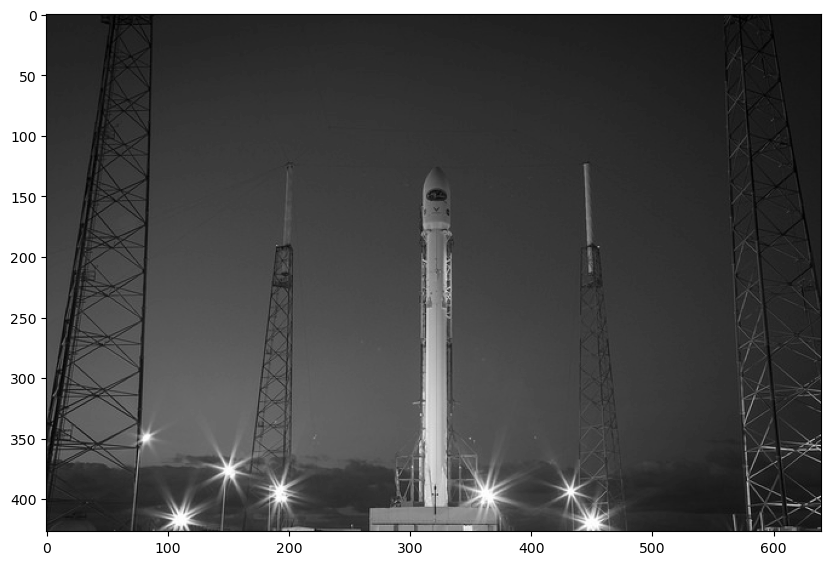

In [166]:
# load image -> rocket image only for demonstration
img_orig = data.rocket()
img  = rgb2gray(img_orig)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")

## Scale space gaussian filtering
For gaussian filtering we use gaussian filter/kernel.

### First method - manual
- We need create gaussian filter.
- After created kernel apply 2D convolution for blurring image.
<img src="../_materials/gauss_function_sigmas.png" width=500>


In [167]:
sigma_0 = 0.7
gauss_vector_0 = signal.gaussian(5, sigma_0)
# sigma = 30
# gauss_vector = signal.gaussian(100, sigma)
gauss_vector_0

array([0.01687988, 0.36044779, 1.        , 0.36044779, 0.01687988])

In [168]:
# Create another signal for demonstrating difference of value distribution
sigma_1 = 5
gauss_vector_1 = signal.gaussian(5, sigma_1)
gauss_vector_1

array([0.92311635, 0.98019867, 1.        , 0.98019867, 0.92311635])

In [169]:
kernel_manual_0 = np.outer(gauss_vector_0,gauss_vector_0)
kernel_manual_1 = np.outer(gauss_vector_1,gauss_vector_1)

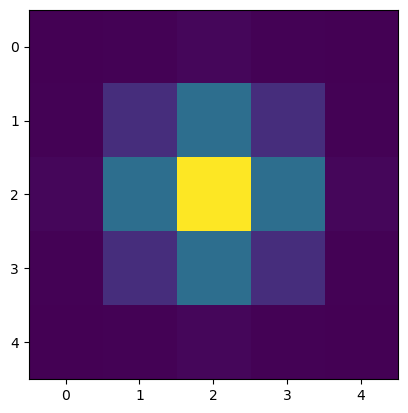

In [170]:
plt.imshow(kernel_manual_0)

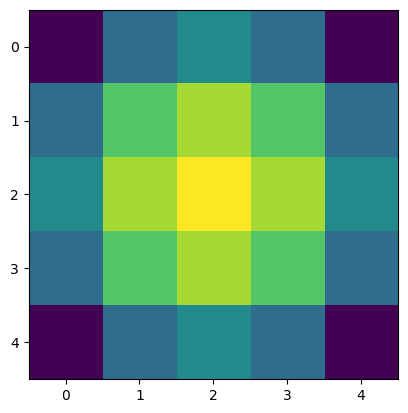

In [171]:
plt.imshow(kernel_manual_1)

In [172]:
# Apply convolution on original image for blurring
gauss_filt_img_0 = signal.convolve2d(img,kernel_manual_0)
gauss_filt_img_1 = signal.convolve2d(img,kernel_manual_1)

Text(0.5, 1.0, 'Gauss filt. img')

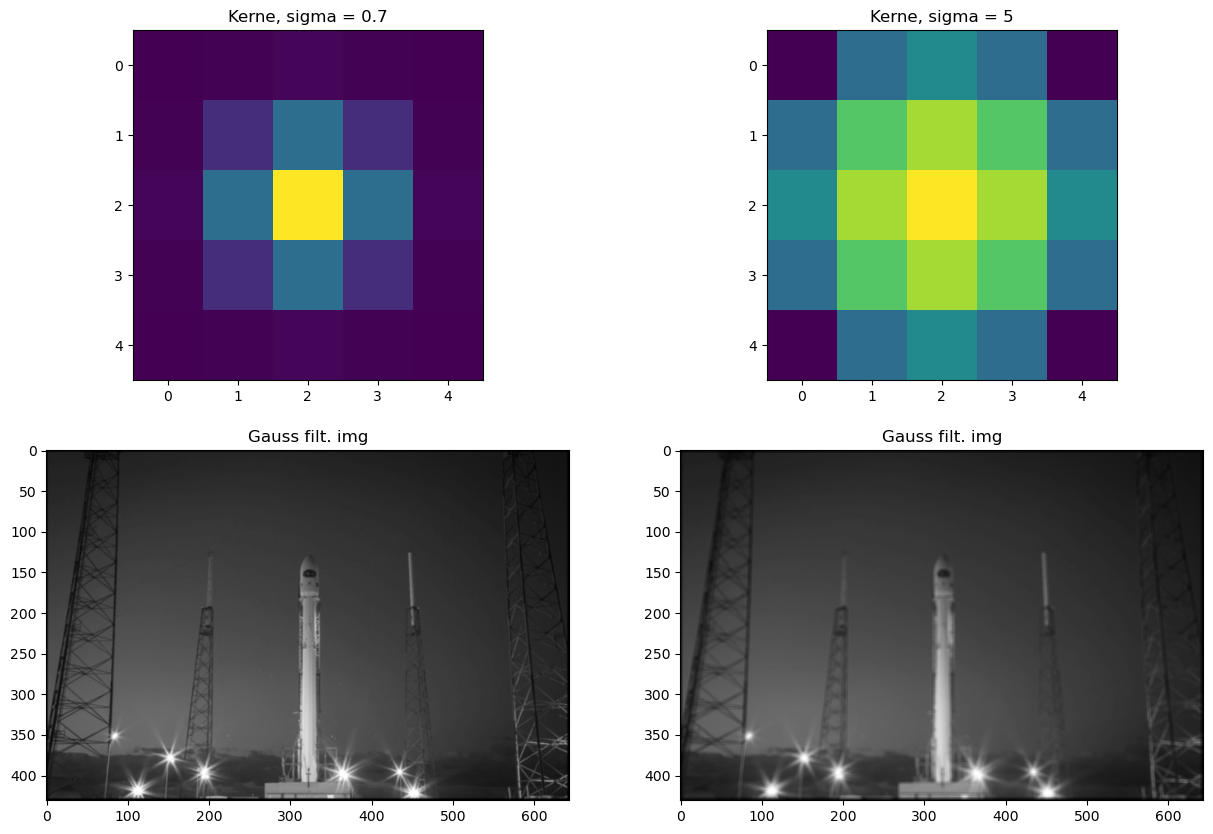

In [173]:
# show
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(kernel_manual_0)
plt.title("Kerne, sigma = {value}".format(value=sigma_0))
plt.subplot(222)
plt.title("Kerne, sigma = {value}".format(value=sigma_1))
plt.imshow(kernel_manual_1)
plt.subplot(223)
plt.title("Gauss filt. img")
plt.imshow(gauss_filt_img_0, cmap="gray")
plt.subplot(224)
plt.imshow(gauss_filt_img_1, cmap="gray")
plt.title("Gauss filt. img")

### Second method - from scipy.ndimage import gaussian_filter

Text(0.5, 1.0, 'Gauss filt. img, sigma = 5')

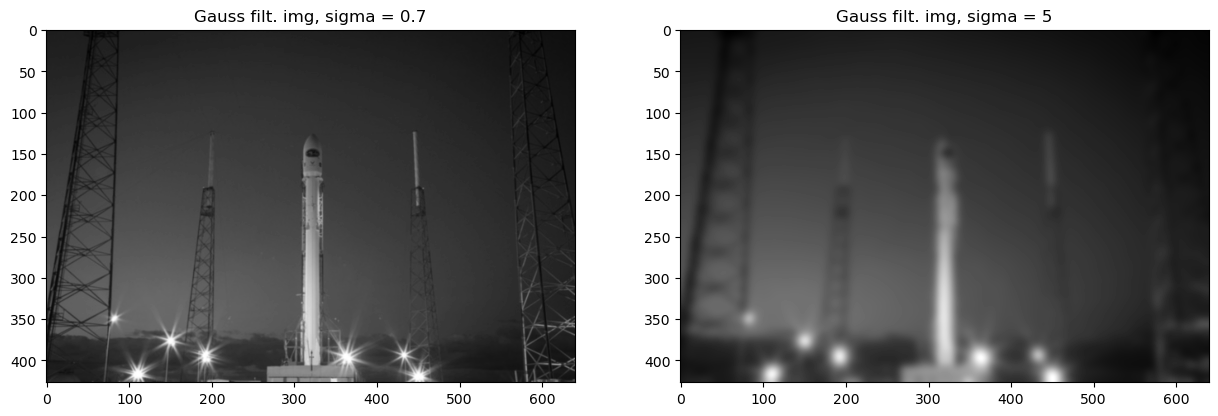

In [174]:
# show
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title("Gauss filt. img, sigma = {value}".format(value=sigma_0))
plt.imshow(gaussian_filter(img,sigma_0), cmap="gray")
plt.subplot(122)
plt.imshow(gaussian_filter(img,sigma_1), cmap="gray")
plt.title("Gauss filt. img, sigma = {value}".format(value=sigma_1))

### Create scale space

In [175]:
# define sigmas
sigmas = [np.sqrt(2)/2,
          1,
          np.sqrt(2),
          2,
          2*np.sqrt(2),
          2*2]

In [176]:
# prepare ndarray for scale space
# shape (x,y,z) ->
# x,y - resolution of blurred image, same as input image
# x -> number of blurred images in scale space
scale_space_array  = np.zeros(shape=(img.shape[0], img.shape[1], len(sigmas)))
scale_space_array.shape

(427, 640, 6)

In [177]:
for i, sigma in zip(range(scale_space_array.shape[2]),sigmas):
    scale_space_array[:,:, i]  = gaussian_filter(img,sigma)

Text(0.5, 0.98, 'Scale space in one Octava')

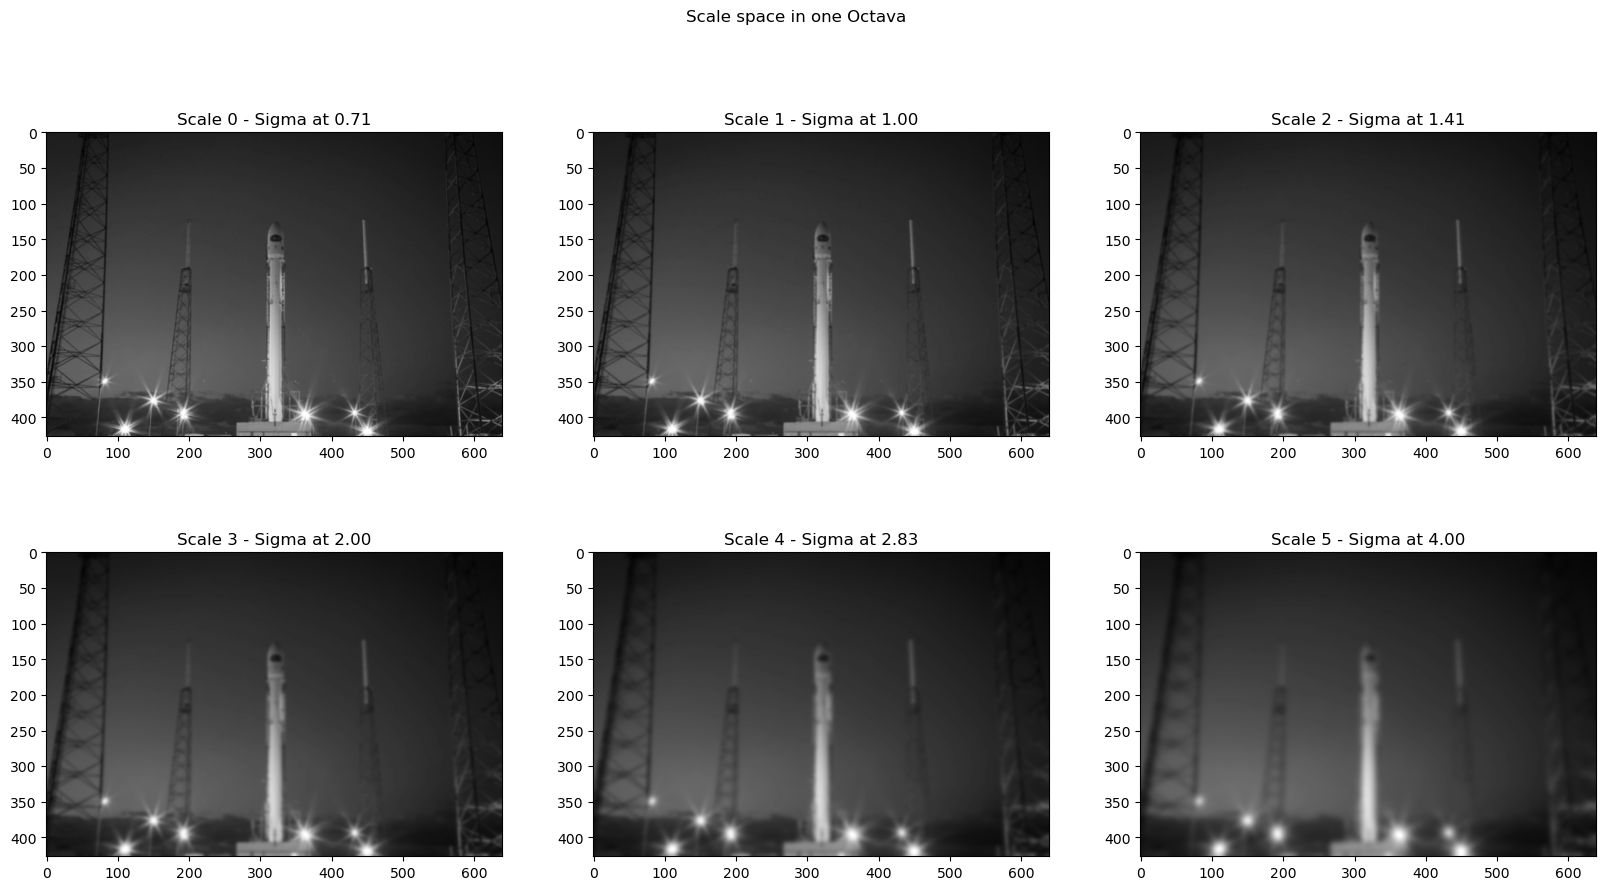

In [178]:
ig, axs = plt.subplots(2, 3,figsize=(20,10))
# axs.title("Scale space in one Octava")
for i, sigma in zip(range(scale_space_array.shape[2]),sigmas):
    axs[i//3,i%3].imshow(scale_space_array[:,:,i], cmap="gray")
    axs[i//3,i%3].set_title("Scale {} - Sigma at {:.2f}".format(i,sigma))
plt.suptitle("Scale space in one Octava")

## DoG - Difference of gaussians

In [179]:
# prepare ndarray for scale space
# shape will be in 3rd position changed -> -1 because scale will subtracted from each other
dog_array = np.zeros(shape=(scale_space_array.shape[0],scale_space_array.shape[1],scale_space_array.shape[2]-1))
dog_array.shape

(427, 640, 5)

In [180]:
for i in range(dog_array.shape[2]):
    dog_array[:,:,i] = scale_space_array[:,:,i]-scale_space_array[:,:,i+1]

Text(0.5, 0.98, 'DoGs in one Octava')

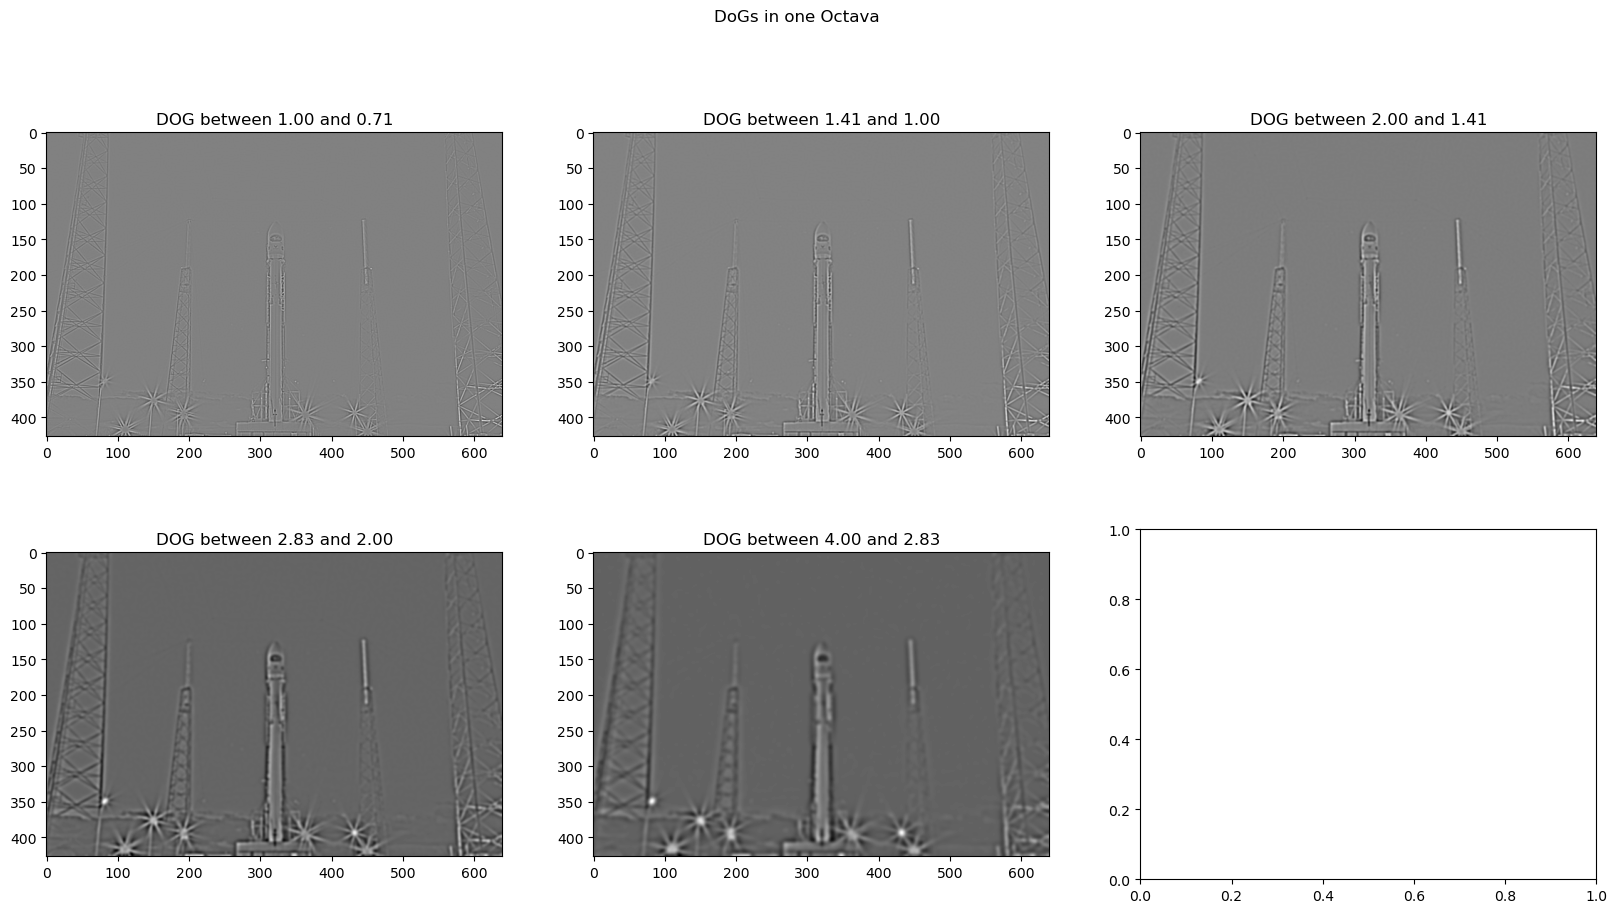

In [181]:
fig, axs = plt.subplots(2, 3,figsize=(20,10))
for i in range(dog_array.shape[2]):
    axs[i // 3,i % 3].imshow(dog_array[:,:,i], cmap="gray")
    axs[i // 3,i % 3].set_title("DOG between {:.2f} and {:.2f}".format(sigmas[i+1],sigmas[i]))
plt.suptitle("DoGs in one Octava")

## Find scale space extremes
We are using multidimensional finding of extremes.

In [182]:
np.set_printoptions(suppress = True)
dog_max_filt = maximum_filter(dog_array,(3,3,3))
dog_min_filt = minimum_filter(dog_array,(3,3,3))

In [183]:
local_max = (dog_array==dog_max_filt)
local_min = (dog_array==dog_min_filt)

In [184]:
# dog_array[0:3,0:3,0:3]

In [185]:
# dog_max_filt[0:3,0:3,0:3]

In [186]:
# local_max[0:3,0:3,0:3]

In [187]:
local_max.shape

(427, 640, 5)

In [188]:
# If in position of original image exist one and more extremes, we marked this point as keypoint.
keypoints = np.logical_or(np.sum(local_max[:,:,1:4],axis=2)>0, np.sum(local_min[:,:,1:4],axis=2)>0)

In [189]:
# Calc all extremes. Extreme is defined as True.
sum(sum(keypoints))

4097

<Figure size 2000x2000 with 0 Axes>

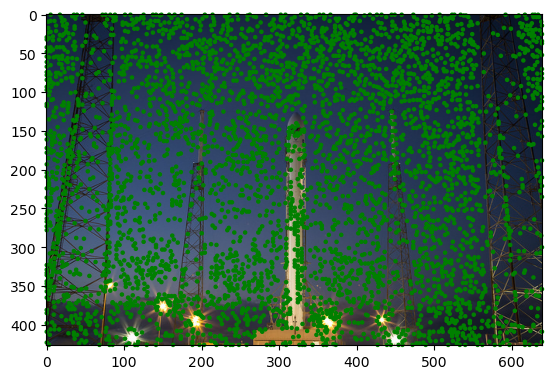

In [190]:
# Plot
plt.figure(figsize=(20,20))
fig, ax = plt.subplots() #
rr, cc = np.where(keypoints)
ax.imshow(img_orig)
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 2, color='g', clip_on=False)
    ax.add_patch(circle1)